In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# prepare the data

In [12]:
h = 0.02  # step size in the mesh

n_samples = 100
datasets = [
    make_moons(n_samples=n_samples, noise=0.2, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_classification(
        n_samples=n_samples,
        n_features=2,
        n_redundant=0,
        n_informative=2,
        random_state=2,
        n_clusters_per_class=1,
    ),
]

The purpose of feature discretization is to reduce the number of continuous variables in a dataset by creating bins or intervals to represent them. This method simplifies the dataset, making it easier to analyze, especially when the number of continuous variables is large. It can also help improve the performance of machine learning algorithms, particularly linear classifiers, by reducing complexity and potentially avoiding overfitting.

# Define Classifiers and Parameters

In [17]:
# list of (estimator, param_grid), where param_grid is used in GridSearchCV
# The parameter spaces in this example are limited to a narrow band to reduce
# its runtime. In a real use case, a broader search space for the algorithms
# should be used.
classifiers = [
    (
        make_pipeline(StandardScaler(), LogisticRegression(random_state=0)),
        {"logisticregression__C": np.logspace(-1, 1, 3)},
    ),
    (
        make_pipeline(StandardScaler(), LinearSVC(random_state=0, dual="auto")),
        {"linearsvc__C": np.logspace(-1, 1, 3)},
    ),
    (
        make_pipeline(
            StandardScaler(),
            KBinsDiscretizer(encode="onehot"),
            LogisticRegression(random_state=0),
        ),
        {
            "kbinsdiscretizer__n_bins": np.arange(5, 8),
            "logisticregression__C": np.logspace(-1, 1, 3),
        },
    ),
    (
        make_pipeline(
            StandardScaler(),
            KBinsDiscretizer(encode="onehot"),
            LinearSVC(random_state=0, dual="auto"),
        ),
        {
            "kbinsdiscretizer__n_bins": np.arange(5, 8),
            "linearsvc__C": np.logspace(-1, 1, 3),
        },
    ),
    (
        make_pipeline(
            StandardScaler(), GradientBoostingClassifier(n_estimators=5, random_state=0)
        ),
        {"gradientboostingclassifier__learning_rate": np.logspace(-2, 0, 5)},
    ),
    (
        make_pipeline(StandardScaler(), SVC(random_state=0)),
        {"svc__C": np.logspace(-1, 1, 3)},
    ),
]


# Visualize the Data


Dataset 0
----------
Logistic Regression: 0.86
Linear SVC: 0.86
KBins + Logistic: 0.86
KBins + Linear SVC: 0.94
Gradient Boosting: 0.90
SVC: 0.94

Dataset 1
----------
Logistic Regression: 0.40
Linear SVC: 0.40
KBins + Logistic: 0.78
KBins + Linear SVC: 0.80
Gradient Boosting: 0.84
SVC: 0.84

Dataset 2
----------
Logistic Regression: 0.98
Linear SVC: 0.96
KBins + Logistic: 0.94
KBins + Linear SVC: 0.94
Gradient Boosting: 0.94
SVC: 0.98


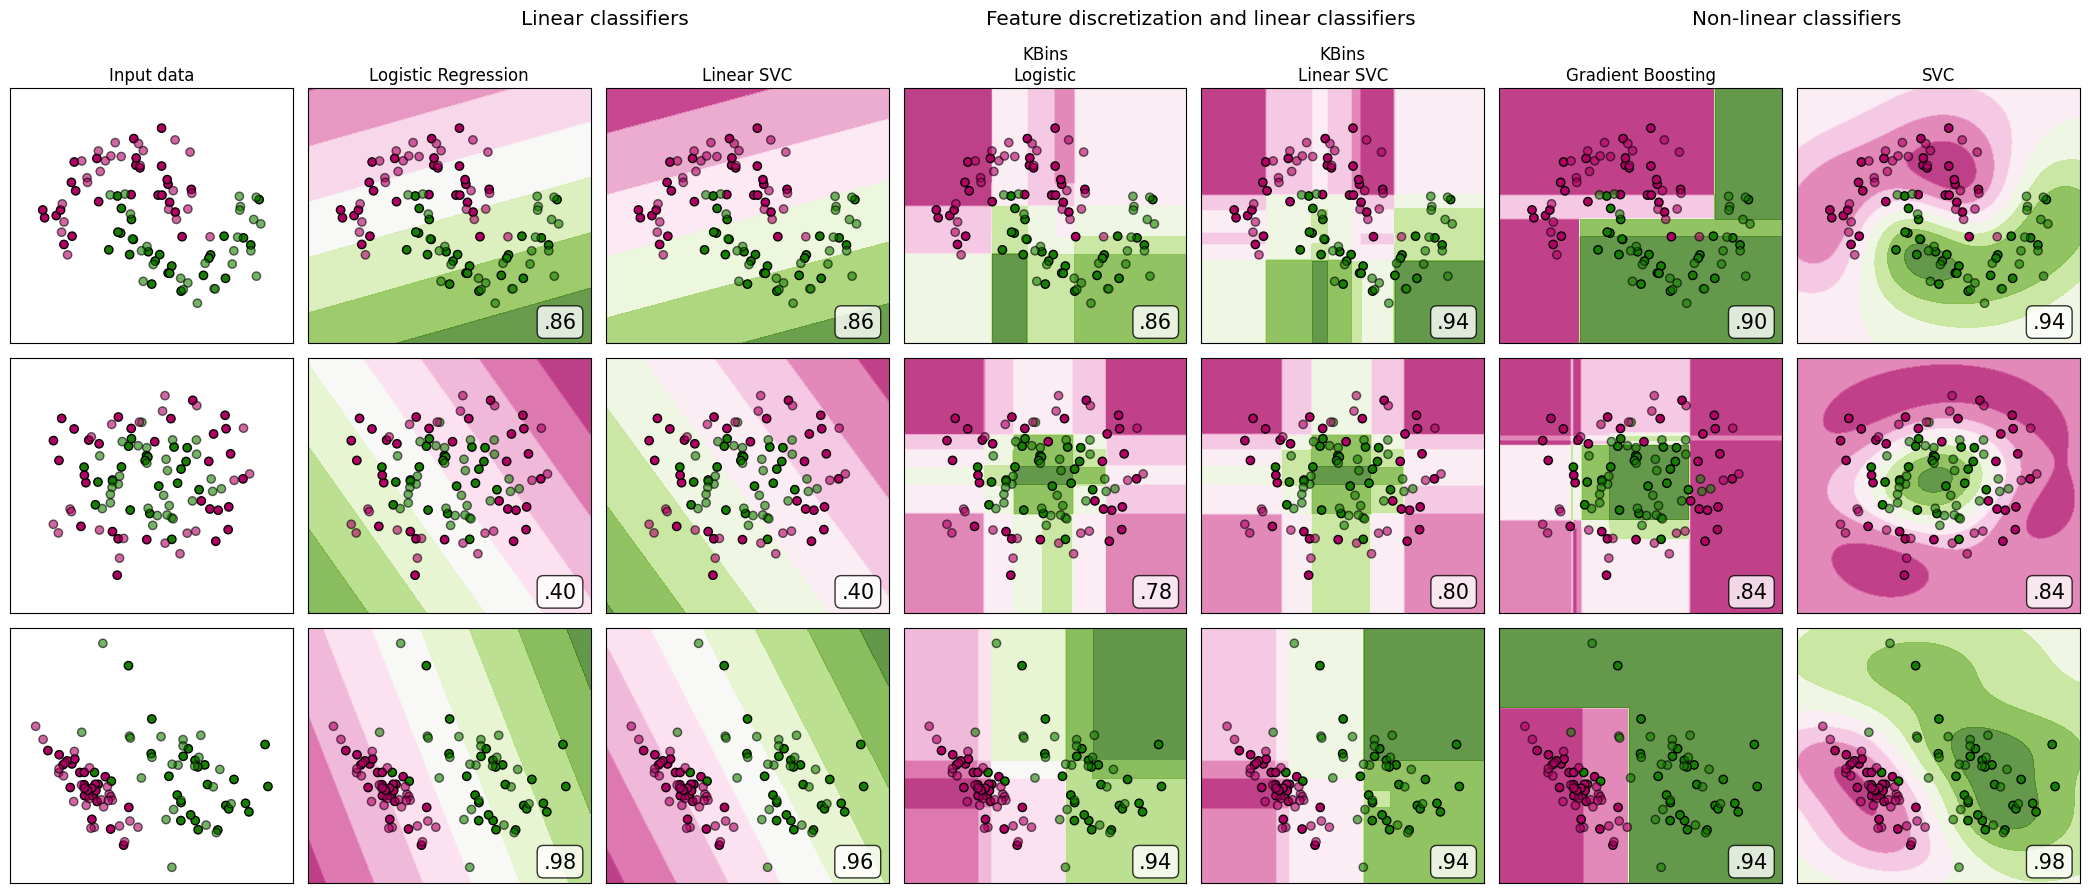

In [18]:
names = [
    "Logistic Regression",
    "Linear SVC",
    "KBins + Logistic",
    "KBins + Linear SVC",
    "Gradient Boosting",
    "SVC",
]

# Prepare plot grid
fig, axes = plt.subplots(
    nrows=len(datasets), ncols=len(classifiers) + 1, figsize=(21, 9)
)

# Loop over datasets
for ds_cnt, (X, y) in enumerate(datasets):
    print(f"\nDataset {ds_cnt}\n" + "-" * 10)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    # Plot input data
    ax = axes[ds_cnt, 0]
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    # Loop over classifiers
    for est_idx, (name, (estimator, param_grid)) in enumerate(zip(names, classifiers)):
        ax = axes[ds_cnt, est_idx + 1]
        clf = GridSearchCV(estimator=estimator, param_grid=param_grid)

        with ignore_warnings(category=ConvergenceWarning):
            clf.fit(X_train, y_train)

        score = clf.score(X_test, y_test)
        print(f"{name}: {score:.2f}")

        try:
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm_piyg, alpha=0.8)
        except Exception as e:
            print(f"Warning: Could not plot decision surface for {name}: {e}")

        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name.replace(" + ", "\n"))
        ax.text(
            0.95, 0.06, f"{score:.2f}".lstrip("0"),
            size=15,
            bbox=dict(boxstyle="round", alpha=0.8, facecolor="white"),
            transform=ax.transAxes,
            horizontalalignment="right",
        )

plt.tight_layout()
plt.subplots_adjust(top=0.90)
suptitles = [
    "Linear classifiers",
    "Feature discretization and linear classifiers",
    "Non-linear classifiers",
]
for i, suptitle in zip([1, 3, 5], suptitles):
    ax = axes[0, i]
    ax.text(
        1.05, 1.25, suptitle,
        transform=ax.transAxes,
        horizontalalignment="center",
        size="x-large",
    )

plt.show()

🔍 Observations


✅ Discretization clearly improves linear models on non-linear datasets (make_moons, make_circles)

Compare the Linear SVC column vs. KBins + Linear SVC → major gain in test accuracy

✅ Gradient Boosting and SVC produce smooth, flexible decision boundaries for non-linear data

⚠️ On the 2nd row (make_circles), plain Logistic Regression and Linear SVC perform poorly (.40)

✅ On the 3rd row (linearly_separable), all models perform very well (up to .98)